In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot style
sns.set_style("white", {'axes.grid': True})
# sns.set_style("whitegrid")
# sns.despine(left=True)

In [3]:
# %load import_notebook.py
# Infraestructure to import a Jupyter notebook
# http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Importing%20Notebooks.html

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
    
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

In [4]:
from LogRegUtils import LogRegModel

importing Jupyter notebook from LogRegUtils.ipynb


In [5]:
# Load data and models

from os.path import isfile, join
from os import listdir

model_name = 'clinical+lab-B1'
isth_data_folder = '../data/2011-15'
isth_data_file = join(isth_data_folder, 'data.csv')
isth_dict_file = join(isth_data_folder, 'dictionary.csv')
isth_data = pd.read_csv(isth_data_file, na_values="\\N")

model_params = join(model_name, 'mice.txt')
model_ranges= join(model_name, 'minmax.txt')
model_oddratios = join(model_name, 'oddratios.txt')

imp_folder = os.path.join(model_name, 'imp')
boot_folder = os.path.join(model_name, 'boot')

imp_data_files = [join(imp_folder, f) for f in listdir(imp_folder) if isfile(join(imp_folder, f))]

model = LogRegModel(model_params)

/Users/andres/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


***************
Risk group low
  Two days  - Mortality=0 N=2
  One week  - Mortality=0 N=10
  Two weeks - Mortality=0 N=39
  More      - Mortality=0 N=15
***************
Risk group medium
  Two days  - Mortality=21 N=0
  One week  - Mortality=2 N=26
  Two weeks - Mortality=12 N=65
  More      - Mortality=20 N=26
***************
Risk group high
  Two days  - Mortality=98 N=3
  One week  - Mortality=71 N=16
  Two weeks - Mortality=58 N=37
  More      - Mortality=61 N=19


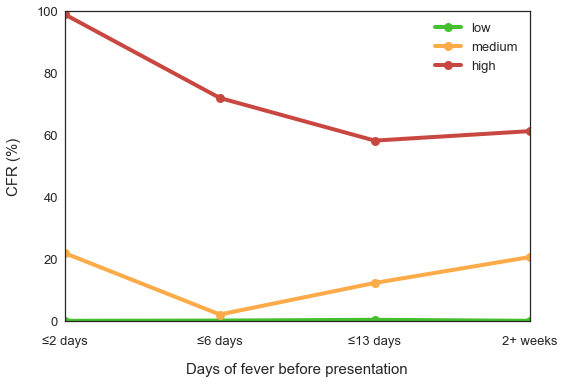

In [11]:
# Iterate over each risk group, and calcualte the average CFR for each DOFBP bin over all imputed datasets

dfbp = 'DOFBP'
variables = ['OUT', 'SN', 'DOFBP'] + model.names

risk_groups = {'low':[0.0, 0.05] , 'medium':[0.05, 0.25], 'high':[0.25, 1.0]}

x = [1, 2, 3, 4]
labels = [u'≤2 days', u'≤6 days', u'≤13 days', '2+ weeks']

label_font_size=15

fig, ax = plt.subplots()
plt.xlabel('Days of fever before presentation', labelpad=15, fontsize=15)
plt.ylabel('CFR (%)', labelpad=15, fontsize=15)
plt.xticks(x, labels, fontsize=13)
plt.yticks(fontsize=13)
plt.ylim([0, 100])
plt.xlim(min(x), max(x))
ax.xaxis.set_tick_params(pad=15)

red="#c94741"
orange="#fdaa48"
green="#46bf2c"
line_colors = {'low':green, 'medium':orange, 'high':red}

for group in ['low', 'medium', 'high']:
    risk0 = risk_groups[group][0]
    risk1 = risk_groups[group][1]
    
    cfr_list0 = []
    cfr_list1 = []
    cfr_list2 = []
    cfr_list3 = []
    n_list0 = []
    n_list1 = []
    n_list2 = []
    n_list3 = []
    
    # Iterave over imputed data files
    for imp_data_file in imp_data_files:
        imp_data = pd.read_csv(imp_data_file, na_values="\\N")
        imp_data['SN'] = isth_data['SN']
        imp_data['DOFBP'] = isth_data['DOFBP']
        model_data = imp_data[variables]
        risk = []
        for sn in model_data['SN']:
            case_data = model_data[model_data['SN'] == int(sn)]
            v = case_data[model_data.columns[3:]].values
            p = model.predict(v)
            risk += [p[0]]
        model_data['RISK'] = risk
    
        test_data = model_data[(risk0 < model_data['RISK']) & (model_data['RISK'] <= risk1)]

        data0 = test_data[test_data[dfbp] <= 2]
        data1 = test_data[(2 < test_data[dfbp]) & (test_data[dfbp] <= 6)]
        data2 = test_data[(6 < test_data[dfbp]) & (test_data[dfbp] <= 13)]
        data3 = test_data[13 < test_data[dfbp]]

        n_list0 += [len(data0)] 
        n_list1 += [len(data1)]
        n_list2 += [len(data2)]
        n_list3 += [len(data3)]        
        if 0 < len(data0): cfr_list0 += [float(len(data0[data0['OUT'] == 1])) / len(data0) * 100]
        else: cfr_list0 += [0]
        if 0 < len(data1): cfr_list1 += [float(len(data1[data1['OUT'] == 1])) / len(data1) * 100]
        else: cfr_list1 += [0]
        if 0 < len(data2): cfr_list2 += [float(len(data2[data2['OUT'] == 1])) / len(data2) * 100]
        else: cfr_list2 += [0]
        if 0 < len(data3): cfr_list3 += [float(len(data3[data3['OUT'] == 1])) / len(data3) * 100]
        else: cfr_list3 += [0]

    # Get mean CFRs        
    cfr0 = np.mean(cfr_list0)
    cfr1 = np.mean(cfr_list1)
    cfr2 = np.mean(cfr_list2)
    cfr3 = np.mean(cfr_list3)
    
    n0 = np.mean(n_list0)
    n1 = np.mean(n_list1)
    n2 = np.mean(n_list2)
    n3 = np.mean(n_list3)    
    
    print '***************'
    print 'Risk group', group    
    print '  Two days  - Mortality=%i N=%i' % (cfr0, n0)
    print '  One week  - Mortality=%i N=%i' % (cfr1, n1)
    print '  Two weeks - Mortality=%i N=%i' % (cfr2, n2)
    print '  More      - Mortality=%i N=%i' % (cfr3, n3)

    # And add plot  
    y = [cfr0, cfr1, cfr2, cfr3]
    plt.plot(x, y, label=group, linewidth=4, markersize=9, marker="o", color=line_colors[group])

plt.legend(loc='upper right', scatterpoints=1, fontsize=13) 
plt.tight_layout()
fig.savefig('DOFBP_RISK.pdf')